In [1]:
import numpy as np
import numpy.random as rand
import matplotlib.pyplot as plt

from numpy.linalg import svd

from sklearn.datasets import make_blobs, make_moons, make_circles
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# Introduction to Neural Networks


## The perceptron

We can think of the perceptron as the simplest neural network, composed by a single artificial neuron. An artificial neuron is a function of the input $\mathbf{x}=(x_1, \ldots , x_M)$ weighted by a vector of connection weights $W={w_1, \ldots w_M}$, completed by a neuron bias $b$ and passed to an activation function $\hat{y}=\phi(f)$

![Perceptron](img/perceptron.png)

$$ \hat{y} = \phi(W^\top x + b )$$

Learning with the perceptron consists in updating the weights:

$$W^{(t+1)}= W^t + \eta (y_i -\hat{y_i})x_i $$ and
$$b^{(t+1)}= b^t + \eta (y_i -\hat{y_i})$$

with $i \in {1, \ldots, N}$, where $\eta$ is the learning rate, $y_i$ is the correct output for the input $x_i$ and $N$ is the size of the training set.

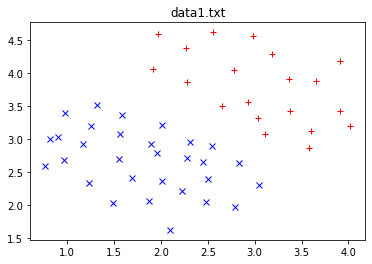

In [2]:
# Load the dataset
fname='data1.txt'
data = np.loadtxt('data/%s' % fname, delimiter=',')
 
X = data[:, 0:2] 
y = data[:, 2]
 
# Plot data 
plt.plot(X[:,0][y == 1], X[:,1][y == 1], 'r+')
plt.plot(X[:,0][y == 0], X[:,1][y == 0], 'bx')
plt.title(fname)
plt.show()


> **Task 1**: Implement the perceptron algorithm, using the step activation function

In [3]:
def activation(x):
    # Step activation
    if x > 0 : return 1
    else : return 0

def perceptron(W,b,x,y,lr):
    """
    Args:
      W (np.array): (INPUT_SHAPE, 1) vector of weights
      b : bias
      x (np.array): (INPUT_SHAPE, 1) input vector
      y : output label (1 or 0)
      lr : learning rate
    Returns:
        (err, W, b) : err is 1 if the predicted label is different from y, 0 otherwise
        W, b : the updated weights and bias
    """
    #insert your solution here
    f= W.T @ x + b
    z = activation(f)
    if y - z != 0:
        W += lr*(y-z) * x
        b += lr*(y-z)
        return (1, W, b)
    else:
        return (0, W, b)

The following cell will run the perceptron on the dataset above and display the decision boundary

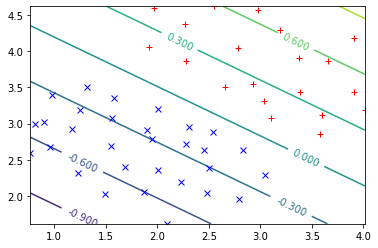

In [4]:
#initialize weights and b
b = 0.0
W = rand.normal(size=(X.shape[1], 1))

errors=1
while errors > 0:
    # start epoch
    errors=0
    for i in range(X.shape[0]):
        xi = X[i,:].reshape(-1,1)
        yi = y[i]
        (err, W, b) = perceptron(W,b,xi,yi, 0.1)
        errors+=err
    #print(errors)
    
#plot decision boundary
fig, ax = plt.subplots()
ax.plot(X[:,0][y == 1], X[:,1][y == 1], 'r+', label="$y=1$")
ax.plot(X[:,0][y == 0], X[:,1][y == 0], 'bx', label="$y=0$")
u = np.linspace(min(X[:, 0]),max(X[:, 0]), 200)
v = np.linspace(min(X[:, 1]),max(X[:, 1]), 200)
z = np.zeros(shape=(len(u), len(v)))
for i in range(len(u)):
    for j in range(len(v)):
        x = np.array([[u[i],v[j]]])
        z[i, j] = W[0]*u[i]+W[1]*v[j]+b
CS=plt.contour(u,v,z.T)
plt.clabel(CS, inline=1, fontsize=10)
plt.show()

## A network for multi-class classification

A perceptron will converge only if the classes are linearly separable. Another problem of the perceptron is that it can only be used for binary classification.

In this section we are going to create a "single-layer network" where the inputs are directly connected to the output layer, in which we have one output unit for each class.

Let's define a *linear layer* as:

$$ \mathbf{z} = W^\top \mathbf{x} + b $$

With $W \in \mathbb{R}^{N \times C} $, while $\mathbf{x}$ and $b$ are vectors of size $C$. $N$ is the dimension of the input and $C$ the number of output units (= number of classes).

The Softmax function maps a vector $z \in \mathbb{R}^C$ to a vector $q \in \mathbb{R}^C$  such that:

$$ q_i(\mathbf{z}) = \frac{e^{z_i}}{\sum_{j \in {\{1, \ldots, C\}}}{e^{z_j}}} \forall i \in {\{1, \ldots, C\}} = Softmax(\mathbf{z})_i $$

Note that: $ 0 \leq q_i \leq 1 \forall i \in {\{1, \ldots, C\}} $, and: $\sum_{i \in {\{1, \ldots, C\}}}{q_i} = 1 $; therefore we can interpret the Softmax function as a function that can normalize any real vector $\mathbf{z}$  into a probability distribution $\mathbf{q}$ over the $C$ values.

With this setup, a "forward pass" corresponds to calculating $\mathbf{z}$ and applying the Softmax to it.

The implementation of the Softmax and a forward pass is as follows:

In [151]:
def softmax(x):
    """
    Takes the output of a layer as input and returns a probability distribution 
    input:
        x (np.array)
    
    returns:
        x (np.array)
    """
    out = np.exp(x)
    
    return out/np.sum(out)

def forward(W, b, x):
    """
    Computes the forward pass and returns the softmax
    input:
        W (np.array): (INPUT_SHAPE, N_CLASSES) The weight matrix of the perceptron
        b (np.array): (N_CLASSES, 1) The bias matrix of the perceptron
        x (np.array): (INPUT_SHAPE, 1) The input of the perceptron

    returns:
        (np.array) (C, 1)
    """
    z = W.T @ x + b
    
    return softmax(z)


In a supervised classification task, we typically use the cross-entropy function on top of the softmax output as a loss function. We use a 1-hot encoded vector for the true distribution $\mathbf{p}(x)$ , where we have $1$ in the position corresponding to the true label $y$ and $0$ elsewhere:

$$
p_i(x) = \left\{
  \begin{array}{@{}ll@{}}
    1, & \text{if}\ y=i \\
    0, & \text{otherwise}
  \end{array}\right.
$$

and the output of the softmax function as our $\mathbf{q}$.

For a single sample $x$, the cross-entropy loss value for these p(x) and q(x) is then:
$$H(p,q)= − \sum_{x}{p(x)\log q(x)}$$

Given that the only non-zero element of the 1-hot vector $p(x)$ is at the $y$ index of the correct class, in practice the $p(x)$ vector is a selector for the $y$ index in the $q(x)$ vector. Therefore, the loss function for a single sample becomes:

$$ Loss = -\log(q_y) = - \log \left( \frac{e^{z_y}}{\sum_{j \in {\{1, \ldots, C\}}}{e^{z_j}}} \right) = - z_y + \log \sum_{j}{e^{z_j}}$$

> **Ques 1**: Derive the gradients of loss with respect to $W$ and $b$.

$$\nabla_W loss = ?$$
$$\nabla_b loss = ?$$

_Solution_:

Let's start by calculating the derivative for each $z_i$ :
$$
\begin{aligned}
\nabla_{z_i}Loss &= \nabla_{z_i}\left( - z_y + \log \sum_{j}{e^{z_j}}\right)\\
&= \nabla_{z_i}\log \sum_{j}{e^{z_j}} - \nabla_{z_i}z_y \\
&= \frac{1}{\sum_{j}{e^{z_j}}}\nabla_{z_i}\sum_{j}{e^{z_j}}- \nabla_{z_i}z_y \\
&= \frac{e^{z_i}}{\sum_{j}{e^{z_j}}} - \nabla_{z_i}z_y \\
&= Softmax(z)_i - \nabla_{z_i}z_y \\
&= Softmax(z)_i - \mathbb{1}(y = i)
\end{aligned}
$$

where $\mathbb{1}(y = i)$ is the one-hot encoded vector of the label:
$$
\mathbb{1}(y = i) = \left\{
  \begin{array}{@{}ll@{}}
    1, & \text{if}\ y=i \\
    0, & \text{otherwise}
  \end{array}\right.
$$

From this result we can observe that:

$\nabla_{z_y} Loss = q_y -1 $ : the gradient for the true label's *logit* is non-positive and decrease proportionally in magnitude as $q_y$ increases.

$ \nabla_{z_i} Loss = q_i  \forall i \neq y $: The rest of the logits gradient ($q_i$) will be non-negative and increase proportionally as $q_i$ increases.

In the specific case of perfect classification where $q_y=1$, the gradient will be $0$ and thus none of the network's parameters will be modified.

Gradients are directed towards the maximal value increase of their function. As expected for our loss function, increasing the probability of the true label's class will decrease the loss, and increasing the probability of each of the incorrect classes will increase the loss. Note that the loss will be infinite if the classifier assigns 0 to the true class. In practice, small values are added to avoid such situation, but we are not considering them here.

We can calculate now the gradient with respect to the $i,j$-th coefficient of $W$:
$$
\begin{aligned}
\frac{\partial Loss}{\partial W_{ij}} &= \frac{\partial Loss}{\partial z_i} \frac{\partial z_i}{\partial W_{ij}}\\
&= (\nabla_{z_i}Loss)_j x_i\\
\nabla_{W}loss &= x \nabla_{z_i}Loss^\top
\end{aligned}
$$

The gradient with respect to the bias is direct: $\nabla_b loss = \nabla_{z_i} loss$

> **Task 2**: Implement the gradients and the loss

In [165]:
def compute_grads(softmaxed, x, y):
    """
    inputs:
        softmaxed (np.array): (N_CLASSES, 1) result of the forward pass
        y (np.array): (N_CLASSES, 1) One-hot encoded vector of the label
        x (np.array): (INPUT_SHAPE, 1) Input vector
        
    returns:
        d_W (np.array): (INPUT_SHAPE, N_CLASSES) Gradient of the loss with respect to the weight matrix
        d_b (np.array): (N_CLASSES, 1) Gradient of the loss with respect to the bias matrix 
    """
    d_out = - y + softmaxed
    d_b = d_out
    d_W = x @ d_out.T
   
    return d_W, d_b

def compute_loss(softmaxed, y):
    """
    loss for a single datapoint
    inputs:
        softmaxed (np.array): (N_CLASSES, 1)
        y (np.array): (N_CLASSES, 1)
        
    returns:
        (float)
    """
    return -np.log(softmaxed)[y==1].sum()

Now, let's generate some data:

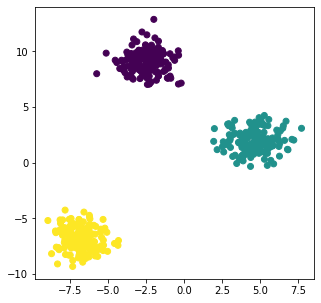

In [166]:
X, Y = make_blobs(n_samples=500, n_features=2, random_state=42)

plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=Y)
plt.show()

#encode output as one-hot
Y = OneHotEncoder(categories='auto').fit_transform(Y.reshape(-1,1)).toarray()

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=42, test_size=0.4)


The following function trains our model:

In [167]:
def train_network(X_train, Y_train, X_test, Y_test, lr,
                    n_it=1000, batch_size=10, random_seed=42):
    
    INPUT_SHAPE = X_train.shape[1]
    N_CLASSES = Y_train.shape[1]
    
    # Initialise metrics lists
    loss = []
    batch_loss = []
    acc = []
    batch_acc = []
    test_acc = []
    
    # Initialisation of the weigths
    np.random.seed(random_seed)
    b = rand.normal(size=(N_CLASSES, 1))
    W = rand.normal(size=(INPUT_SHAPE, N_CLASSES))
    
    # Shuffling data for SGD
    indexes = rand.randint(X_train.shape[0], size=n_it)
    # training loop
    for it, i in enumerate(indexes):
        x = X_train[i,:].reshape(-1,1)
        y = Y_train[i,:].reshape(-1,1)
        
        # Forward pass
        softmaxed = forward(W, b, x)
        
        # Gradient calculation
        d_W, d_b = compute_grads(softmaxed, x, y)
        W -= lr * d_W
        b -= lr * d_b
        
        # Metrics recording
        batch_loss.append(compute_loss(softmaxed, y))
        batch_acc.append(np.argmax(softmaxed) == np.argmax(y))
        
        # Test loop
        if it % batch_size == 0:
            acc_temp = []
            for i in range(X_test.shape[0]):
                x = X_test[i,:].reshape(-1,1)
                y = Y_test[i,:].reshape(-1,1)
                softmaxed = forward(W, b, x)
                acc_temp.append(np.argmax(softmaxed) == np.argmax(y))
                
            test_acc.append(np.mean(acc_temp))
            loss.append(np.mean(batch_loss))
            acc.append(np.mean(batch_acc))
            batch_loss=[]
            batch_acc=[]

    return W, b, loss, acc, test_acc

Now, let's train the model on the data and observe the results:

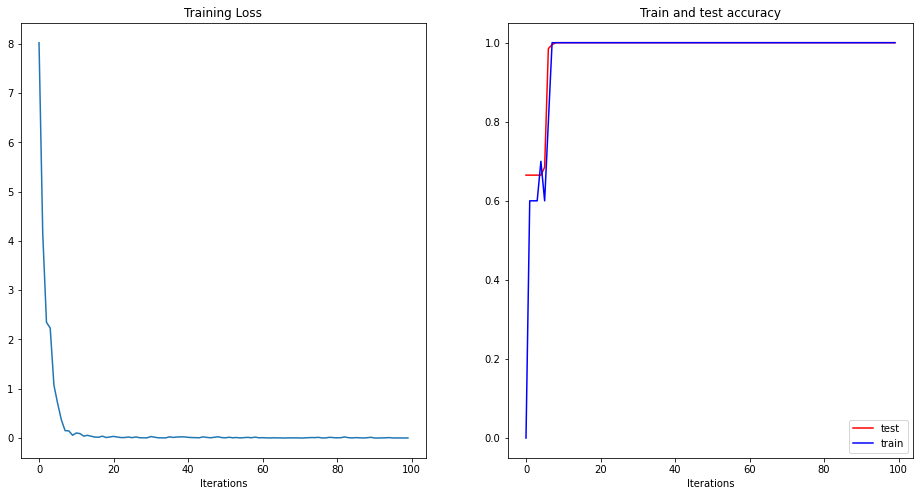

In [168]:
W, b, loss, acc, test_acc = train_network(X_train, Y_train, X_test, Y_test, lr=0.01, n_it=1000)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))
ax1.plot(loss)
ax1.set_title("Training Loss")
ax1.set_xlabel("Iterations")
ax2.plot(test_acc, c='r', label='test')
ax2.plot(acc, c='b', label='train')
ax2.set_title("Train and test accuracy")
ax2.set_xlabel("Iterations")
plt.legend()
plt.show()


Now we can visualize the decision boundaries:

In [169]:
def plot_decision(X, Y, forward_fun, figure=None):
    """Plots the decision function of a perceptron with respect to a forward funciton
    
    input:
        X, Y (np.array): Test data
        forward_fun (function): only accepts x as input (Ex: lambda x: forward_network(W, b, x))
        figure (plt.figure): optional, usefull if you dont want to generate any new figure, 
                    in the case of suplots.
    """
    markers=[".", "*", "D"]
    low0, high0 = np.min(X[:,0]), np.max(X[:,0])
    low1, high1 = np.min(X[:,1]), np.max(X[:,1])
    data = np.zeros((100,100,Y.shape[1]))
    for i1, x1 in enumerate(np.linspace(low0,high0,100)):
        for i2, x2 in enumerate(np.linspace(low1,high1,100)):
            x = np.array([x1, x2]).reshape(-1, 1)
            softmaxed = forward_fun(x)
            data[i2, i1, :] = softmaxed.reshape(-1)
    if Y.shape[1] < 3:
        data = data[:,:,0]
    
    if figure is None:
        plt.figure(figsize=(10,10))
        
    plt.imshow(data, extent=(low0,high0,low1,high1), origin='lower', interpolation='gaussian')
    for c in range(Y.shape[1]):
        plt.scatter(X[np.argmax(Y, 1) == c, 0], X[np.argmax(Y, 1) == c, 1], c='k', 
                    marker=markers[c], label="class %i" % c)
        
    plt.legend()

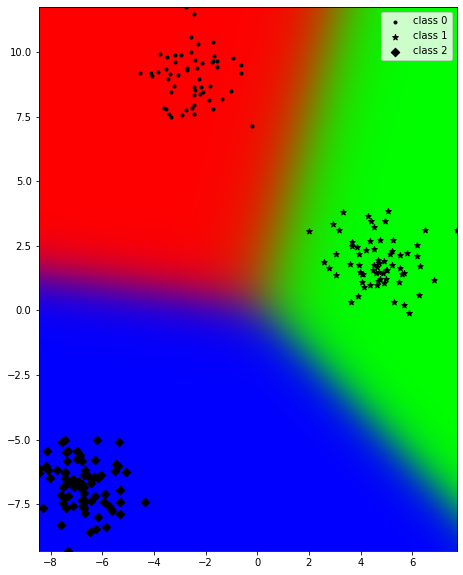

In [170]:
plot_decision(X_test, Y_test, lambda x: forward(W, b, x))

The data we used was linearly separable, so let's take a look at how our network would perform on a different dataset: 

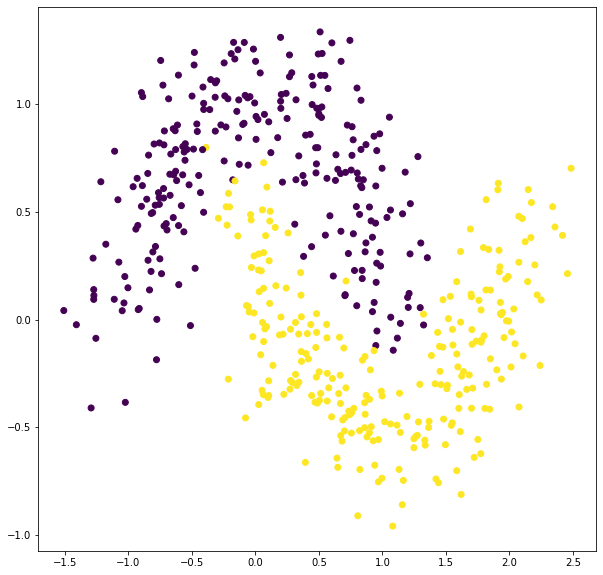

In [171]:
X, Y = make_moons(n_samples=500, noise=.2)
plt.figure(figsize=(10,10))
plt.scatter(X[:,0], X[:,1], c=Y)
plt.show()
Y = OneHotEncoder(categories='auto').fit_transform(Y.reshape(-1,1)).toarray()

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=42, test_size=0.4)

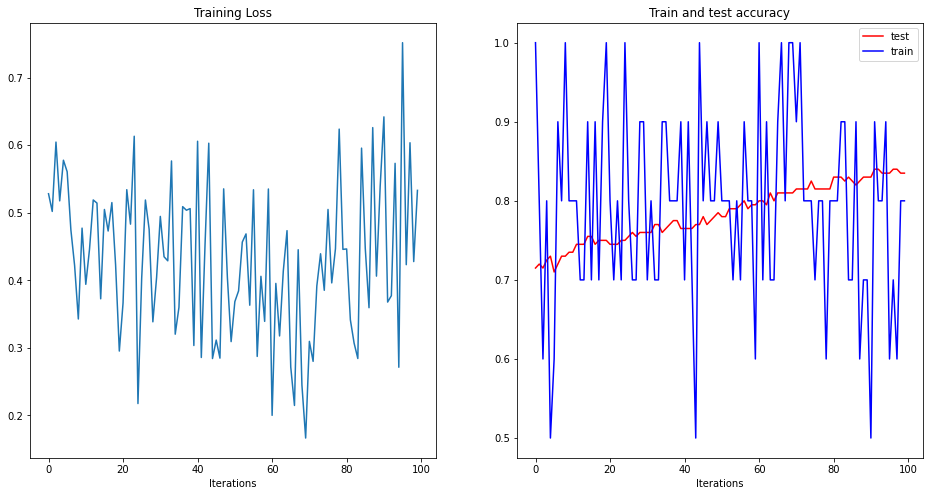

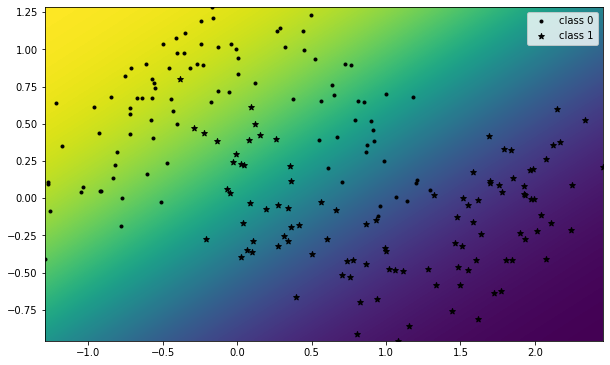

In [172]:
W, b, loss, acc, test_acc = train_network(X_train, Y_train, X_test, Y_test, 0.01)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))
ax1.plot(loss)
ax1.set_title("Training Loss")
ax1.set_xlabel("Iterations")
ax2.plot(test_acc, c='r', label='test')
ax2.plot(acc, c='b', label='train')
ax2.set_title("Train and test accuracy")
ax2.set_xlabel("Iterations")
plt.legend()
plt.show()
plot_decision(X_test, Y_test, lambda x: forward(W,b,x))

# Our first neural network

To obtain non linearity, we need at least one **hidden layer** with a non-linear activation function; in this case we are going to study a case in which the activation chosen for the hidden layer is the $ReLU$ function:

$$ z = W^\top x + b_1 $$

$$ h = ReLU(W^\top x + b_1) = ReLU(z) $$

We will use the Softmax seen in the previous case as the output layer:

$$ \theta = U^\top h + b_2 $$

$$ \hat{y} = Softmax(\theta) $$

With $U \in \mathbb{R}^{N \times H}$ and $W \in \mathbb{R}^{C \times H}$ and $b_1$, $b_2$ vectors of corresponding dimensions. $H$ is the number of hidden units.

The $ReLU$ function is defined as:

$$ ReLU(x) = 
\begin{cases}
0 \textrm{ if } x < 0\\
x \textrm{ otherwise }
\end{cases}
$$

and it's immediate to observe that the derivative of the ReLU function is: $sgn(ReLU(x)) $.

> **Task 3**: Implement the ReLU activation function, the derivative of the relu, and the forward pass for the neural network.

In [210]:
def relu(x):
    """
    input:
        x (np.array)
    
    returns:
        x (np.array)
    """
    return np.clip(x, 0, np.infty)

def d_relu(x):
    """Computes the derivative of the relu
    input:
        x (np.array)
    
    returns:
        x (np.array)
    """
    return (x > 0).astype(int)

def forward_NN(U, b2, W, b1, x):
    """Forward pass of a two layer perceptron with relu activation
    input:
        W (np.array): (INPUT_SHAPE, HIDDEN_SHAPE) The weight matrix of the hidden layer
        U (np.array): (HIDDEN_SHAPE, N_CLASSES) The weight matrix of the output layer
        b1 (np.array): (HIDDEN_SHAPE, 1) The bias matrix of the hidden layer
        b2 (np.array): (N_CLASSES, 1) The bias matrix of the output layer
        x (np.array): (INPUT_SHAPE, 1) The input of the perceptron

    returns:
        softmaxed (np.array): (N_CLASSES, 1) the output of the network after final activation
        hidden (np.array): (HIDDENT_SHAPE, 1) the output of the hidden layer after activation
        out (np.array): (N_CLASSES, 1) the output of the network before final activation
    """
    hidden = relu(W.T @ x + b1)
    out = U.T @ hidden + b2
    
    return softmax(out), hidden, out
    

Putting all of the above together, we can see that:


$$ q_i(\mathbf{\theta}) = \frac{e^{\theta_i}}{\sum_{j \in {\{1, \ldots, C\}}}{e^{\theta_j}}} \forall i \in {\{1, \ldots, C\}} = Softmax(\mathbf{\theta})_i = \hat{y}_i$$

and therefore the loss is:

$$
Loss = -\log(\hat{y}_y) = - \log \left( \frac{e^{\theta_y}}{\sum_{j \in {\{1, \ldots, C\}}}{e^{\theta_j}}} \right) = - \theta_y + \log \sum_{j}{e^{\theta_j}}$$

> **Ques 2** : Derive the gradients of the loss with respect to $W$, $U$, $b_1$ and $b_2$.

_Solution_:


let's write the chain rule for $\frac{\partial Loss}{\partial U}$ and $\frac{\partial Loss}{\partial b_2}$:

$$
\frac{\partial Loss}{\partial U} = \frac{\partial Loss}{\partial \hat{y}}\frac{\partial \hat{y}}{\partial \theta}\frac{\partial \theta}{\partial U}
$$
$$
\frac{\partial Loss}{\partial b_2} = \frac{\partial Loss}{\partial \hat{y}}\frac{\partial \hat{y}}{\partial \theta}\frac{\partial \theta}{\partial b_2}
$$

Notice that $\frac{\partial Loss}{\partial \hat{y}}\frac{\partial \hat{y}}{\partial \theta} = \frac{\partial Loss}{\partial \theta}$ is present in both derivatives. We will define some variables to represent the intermediate derivatives:

$$
\delta_1 = \frac{\partial Loss}{\partial \theta} ; \hspace{1cm} \delta_2 = \frac{\partial Loss}{\partial z}
$$

These can be thought as the error signals passed down to $\theta$ and $z$ when doing backpropagation. We can compute them as follows:

$$
\delta_1 = \frac{\partial Loss}{\partial \theta} = Softmax(\theta) - y
$$

as it results from Ques 1; and

$$
\begin{aligned}
\delta_2 &= \frac{\partial Loss}{\partial z} = \frac{\partial Loss}{\partial \theta}\frac{\partial \theta}{\partial h}\frac{\partial h}{\partial z}\\
&= \delta_1 \frac{\partial \theta}{\partial h}\frac{\partial h}{\partial z}\\
&= \delta_1 U \frac{\partial h}{\partial z}\\
&= \delta_1 U \circ sgn(h)\\
\end{aligned}
$$

Now we can use the error terms to compute our gradients.

$$
\frac{\partial Loss}{\partial U} = \frac{\partial Loss}{\partial \theta} \frac{\partial \theta}{\partial U} = \delta_1 \frac{\partial \theta}{\partial U} = \delta_{1}^\top h^\top
$$
$$
\frac{\partial Loss}{\partial b_2} = \frac{\partial Loss}{\partial \theta} \frac{\partial \theta}{\partial b_2} = \delta_1 \frac{\partial \theta}{\partial b_2} = \delta_{1}^\top
$$
$$
\frac{\partial Loss}{\partial W} = \frac{\partial Loss}{\partial z} \frac{\partial z}{\partial W} = \delta_2 \frac{\partial z}{\partial W} = \delta_{2}^\top x^\top
$$
$$
\frac{\partial Loss}{\partial b_1} = \frac{\partial Loss}{\partial z} \frac{\partial z}{\partial b_1} = \delta_2 \frac{\partial z}{\partial b_1} = \delta_{2}^\top
$$


> **Task 4**: Based on the previous result implement the computation of the gradients.

In [228]:
def compute_grads_NN(hidden, softmaxed, U, x, y):
    """Forward pass of a one layer perceptron with relu activation
    input:
        hidden (np.array): (HIDDEN_SHAPE, 1) the output of the hidden layer after activation
        softmaxed (np.array): (N_CLASSES, 1) the output of the network after final activation
        U (np.array): (HIDDEN_SHAPE, N_CLASSES) The weight matrix of the output layer
        x (np.array): (INPUT_SHAPE, 1) The input of the perceptron
        y (np.array): (N_CLASSES, 1) Ground truth class
    
    returns:
        d_U (np.array): (HIDDEN_SHAPE, N_CLASSES) Gradient with respect 
                        to the weight matrix of the output layer
        d_b2 (np.array): (N_CLASSES, 1) Gradient with respect to the bias matrix of the output layer
        d_W (np.array): (INPUT_SHAPE, HIDDEN_SHAPE) Gradient with respect to the 
                        weight matrix of the hidden layer
        d_b1 (np.array): (HIDDEN_SHAPE, 1) Gradient with respect to the bias matrix of the hidden layer
    """
    
    d_out = - y + softmaxed
    d_b2 = d_out
    d_U = hidden * d_out.T 
    d_hidden = d_relu(hidden)
    d_W = x * d_hidden.T * (U @ d_out).reshape(-1)
    d_b1 = d_hidden * (U @ d_out).reshape(-1,1)
   
    return d_U, d_b2, d_W, d_b1

The following function trains the network:

In [229]:
def train_NN(X_train, Y_train, X_test, Y_test, lr, n_hidden,
                    n_it=1000, batch_size=10, random_seed=42):

    HIDDEN_SHAPE = n_hidden
    INPUT_SHAPE = X_train.shape[1]
    N_CLASSES = Y_train.shape[1]
    
    # Initialise metrics lists
    loss = []
    acc = []
    test_acc = []
    
    # Initialisation of the weigths
    np.random.seed(random_seed)
    b1 = rand.normal(size=(HIDDEN_SHAPE, 1))
    W = rand.normal(size=(INPUT_SHAPE, HIDDEN_SHAPE))
    b2 = rand.normal(size=(N_CLASSES, 1))
    U = rand.normal(size=(HIDDEN_SHAPE, N_CLASSES))
    
    # Shuffling data
    indexes = rand.randint(X_train.shape[0], size=n_it)
    
    # training loop
    for it, i in enumerate(indexes):
        x = X_train[i,:].reshape(-1,1)
        y = Y_train[i,:].reshape(-1,1)

        # Forward pass
        softmaxed, hidden, out = forward_NN(U, b2, W, b1, x)
        # Back probagaiton
        d_U, d_b2, d_W, d_b1 = compute_grads_NN(hidden, softmaxed, U, x, y)
        
        #update weights
        b1 -= lr * d_b1  
        W -= lr * d_W
        b2 -= lr * d_b2
        U -= lr * d_U   
        
        # Metrics recording
        loss.append(compute_loss(softmaxed, y))
        acc.append(np.argmax(softmaxed) == np.argmax(y))
        
        # Test loop
        if it % batch_size == 0:
            acc_temp = []
            for i in range(X_test.shape[0]):
                x = X_test[i,:].reshape(-1,1)
                y = Y_test[i,:].reshape(-1,1)
                softmaxed, _, _ = forward_NN(U, b2, W, b1, x)
                acc_temp.append(np.argmax(softmaxed) == np.argmax(y))
                
            test_acc.append(np.mean(acc_temp))

    return U, b2, W, b1, loss, acc, test_acc

Let's train our network:

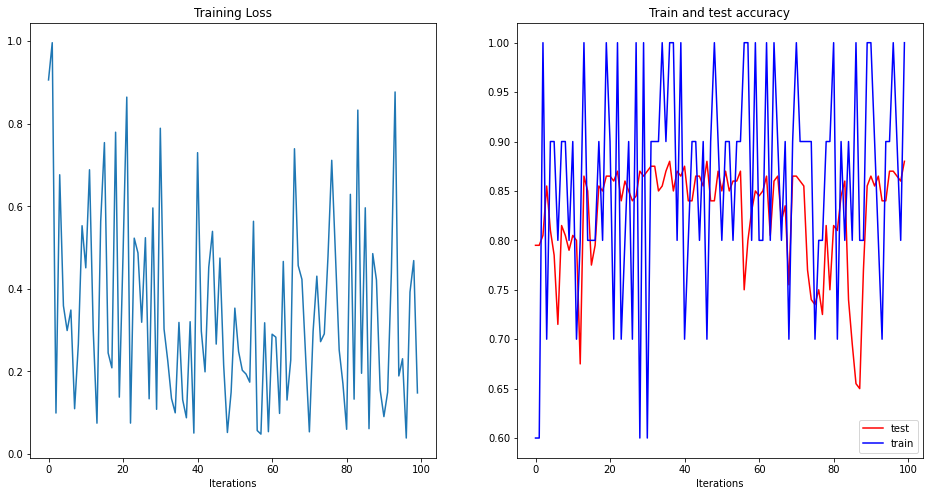

In [230]:
U, b2, W, b1, loss, acc, test_acc = train_NN(X_train, Y_train, X_test, Y_test, 0.1, 16)

def rollmean(x, window):
    return [np.mean(x[i*window:(i+1)*window]) for i in range(len(x)//window)]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))
window=10
ax1.plot(rollmean(loss, window))
ax1.set_title("Training Loss")
ax1.set_xlabel("Iterations")
ax2.plot(test_acc, c='r', label='test')
ax2.plot(rollmean(acc, window), c='b', label='train')
ax2.set_title("Train and test accuracy")
ax2.set_xlabel("Iterations")
plt.legend()
plt.show()

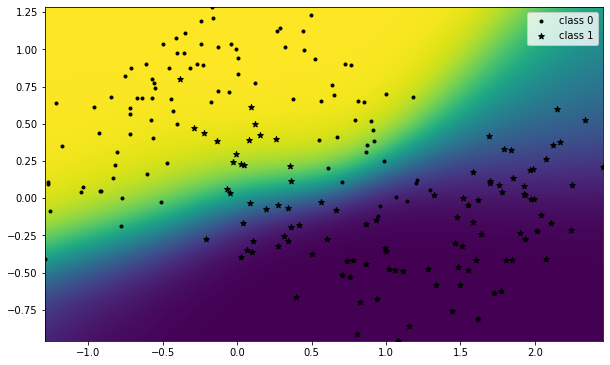

In [231]:
plot_decision(X_test, Y_test, lambda x: forward_NN(U, b2, W, b1, x)[0])

Let's verify how the network performs if we modify the size of the hidden layer (2, 4, 8, 16 hidden units):

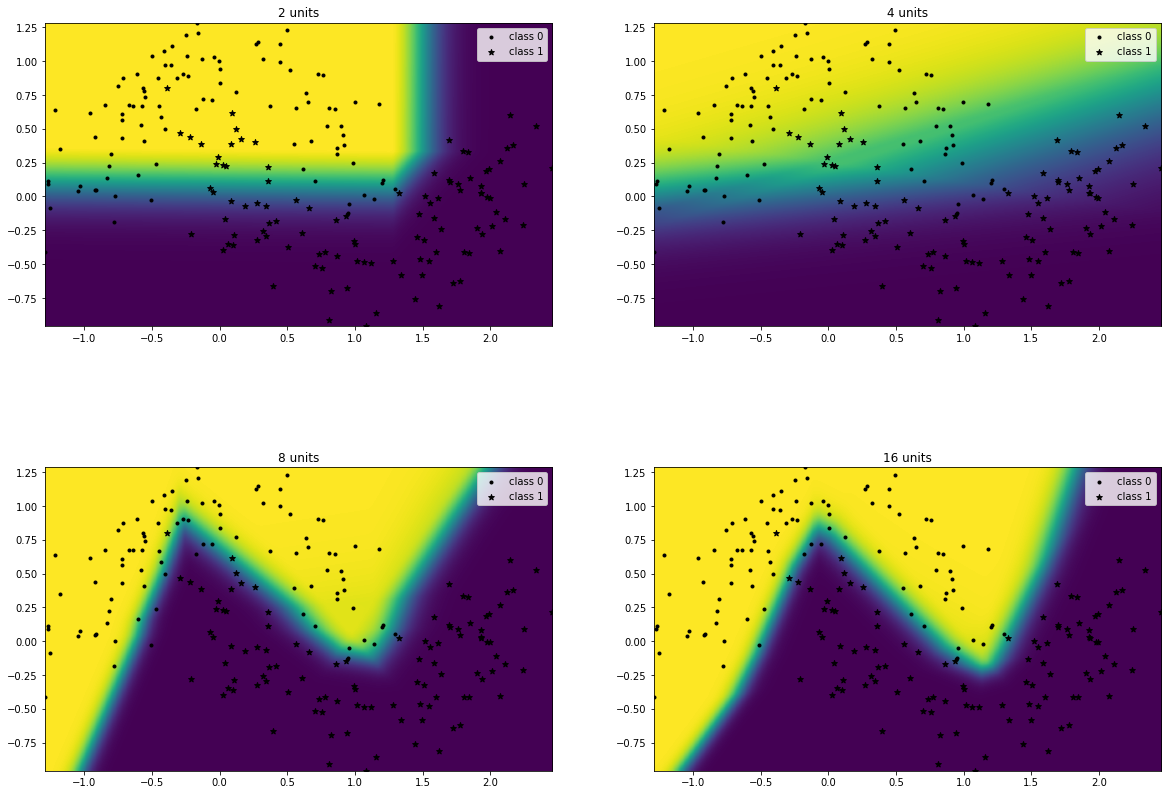

In [215]:
plt.figure(figsize=(20,15))
for i, n_units in enumerate([2, 4, 8, 16]):
    U, b2, W, b1, loss, acc, test_acc = train_NN(X_train, Y_train, X_test, Y_test, 
                                                          0.1, n_units, n_it=5000)
    plot_decision(X_test, Y_test, lambda x: forward_NN(U, b2, W, b1, x)[0],
                  plt.subplot(2,2,i+1, title="%i units" % n_units))

We would like now to study the effect of using a different activation function. We will change ReLU to the hyperbolic tangent activation (or *tanh*):

$$
tanh(x) = \frac{e^{2x}-1}{e^{2x}+1}
$$

(Note: you may use the Numpy implementation of tanh)

with derivative (necessary to update the gradient computation): $ tanh'(x) =  1 - tanh(x)^2$ 


> **Task 5**: Update the forward pass and gradient computation of our neural network implementation to use the tanh activation function and vizualize the result.

In [232]:
def forward_NN(U, b2, W, b1, x):
    
    hidden = np.tanh(W.T @ x + b1)
    out = U.T @ hidden + b2
    
    return softmax(out), hidden, out
    
def compute_grads_NN(hidden, softmaxed, U, x, y):
    d_out = - y + softmaxed
    d_b2 = d_out
    d_U = hidden * d_out.T 
    d_hidden = 1 - np.tanh(hidden)**2
    d_W = x * d_hidden.T * (U @ d_out).reshape(-1)
    d_b1 = d_hidden * (U @ d_out).reshape(-1,1)
       
    return d_U, d_b2, d_W, d_b1


Visualisation of boundary:

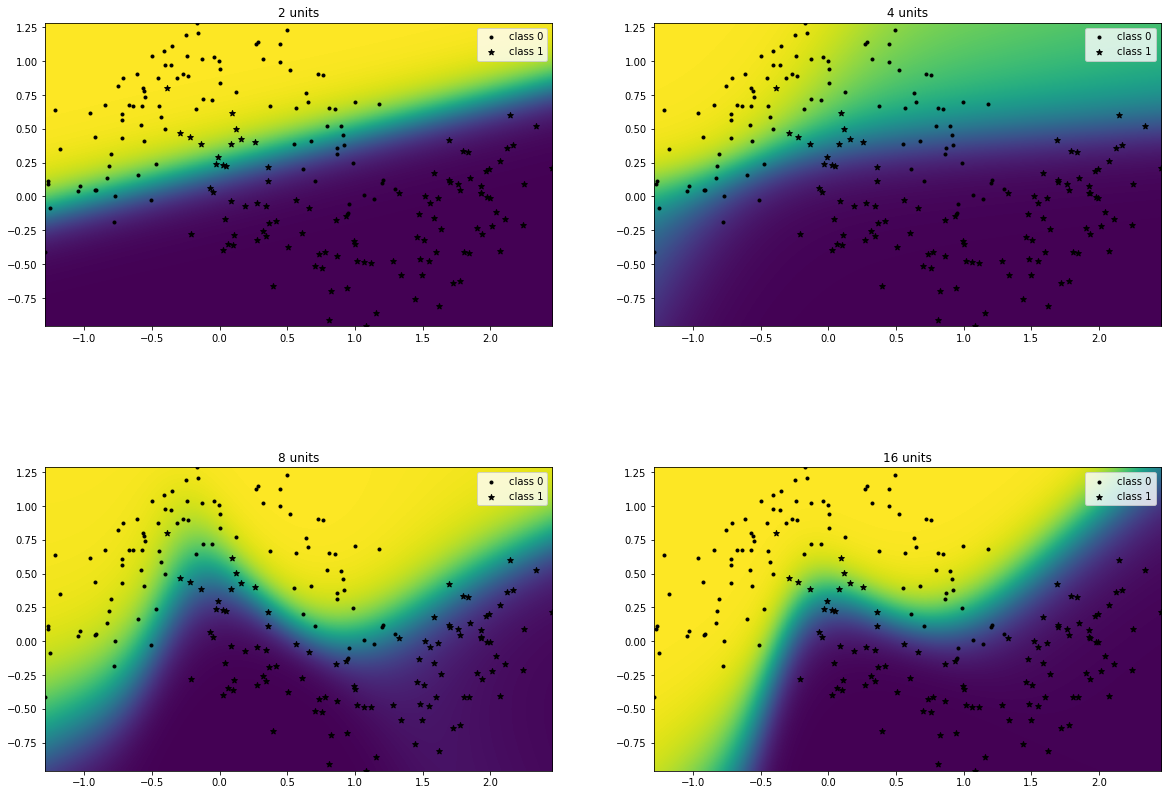

In [233]:
plt.figure(figsize=(20,15))
for i, n_units in enumerate([2, 4, 8, 16]):
    U, b2, W, b1, loss, acc, test_acc = train_NN(X_train, Y_train, X_test, Y_test, 
                                                          0.1, n_units, n_it=1000)
    plot_decision(X_test, Y_test, lambda x: forward_NN(U, b2, W, b1, x)[0],
                  plt.subplot(2,2,i+1, title="%i units" % n_units))

plt.show()